# Parameter Tuning for Advance Lane Finding Pipeline
In the Previous project, Canny edge detection and Hough Transformation have limitations on handling shadows, and the constant threshold would not play well with a constantly changing driving environment. A more robust image process logic is require to get a good lane detecting result

## Approach to a more robust Lane Finding Algorithms 
The approach would be shown in the following steps
1. Camera Calibration and Distortion Correction
2. Color and Gradient Threshold Filter
3. Perspective Transform Calculation
4. Sliding Window Lane Line Finding
5. Curvature Measurement

In this notebook, I will go over the all parameter tuning code and tuning result. The actual pipeline code would be in a different notebook.

**Important! A good image process will make later pipeline logic more accurate! This is almost half of the job! **

## Package Import

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#glob is used to reading all the similar calbration image
import glob

# import all cal images
cal_images = glob.glob ('camera_cal/calibration*.jpg')

## Camera Calibration
Using Chessboard images taken from different angle to calibrate the image distortion for our camera

In [2]:
# Arrays to store object points and image points from all images

objpoints = []
imgpoints = []

# Obj points should not change and only based on the chesss board format
# Preparing object points, like (0,0,0), (1,0,0) ...
objp = np.zeros((6*9,3),np.float32)
 
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # Creating x y coordinates

for fname in cal_images:
    # read in each image
    img = mpimg.imread(fname)
    
    # Convert to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find Chesse board corners
    ret, corners = cv2.findChessboardCorners (gray, (9,6),None)
    
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        img = cv2.drawChessboardCorners(img,(9,6),corners,ret)
        #print (fname)
        mpimg.imsave('temp_output/'+fname, img)

Here is the output check on the finding corners
![corners](temp_output/camera_cal/calibration2.jpg)
Once I have all the Corners found and append into the imgpoints, I can operate camera calibration by using cv2 camera calibration

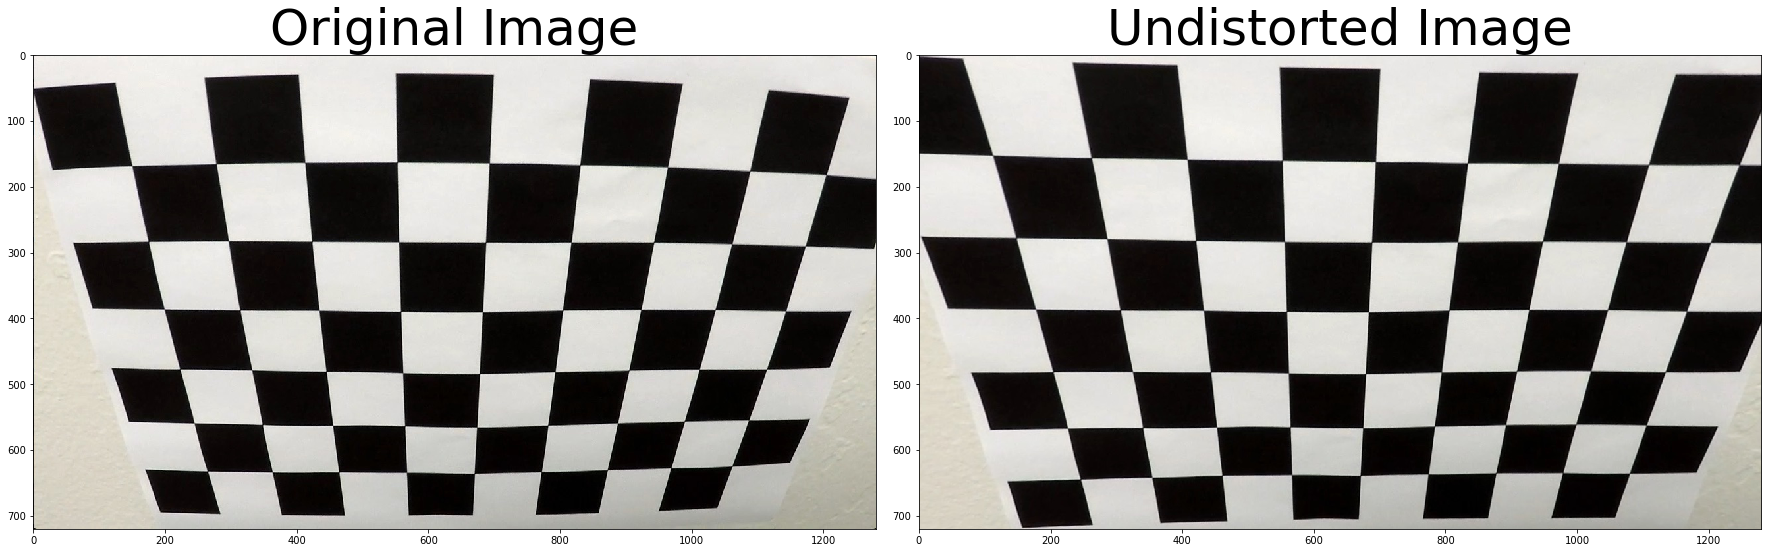

In [3]:

ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,
                                               img.shape[1:],None,None)
# Test the undistort on calibration2.jpg
test_undis_img = mpimg.imread('camera_cal/calibration2.jpg')
undist = cv2.undistort(test_undis_img,mtx,dist,None,mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_undis_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Color Threshold
Let's find out which color space is the best for our test images

First let's have a function will print all plots to visullize the reslut. This plot method is refereced from [Naoki Shibuya](https://github.com/naokishibuya/car-finding-lane-lines)

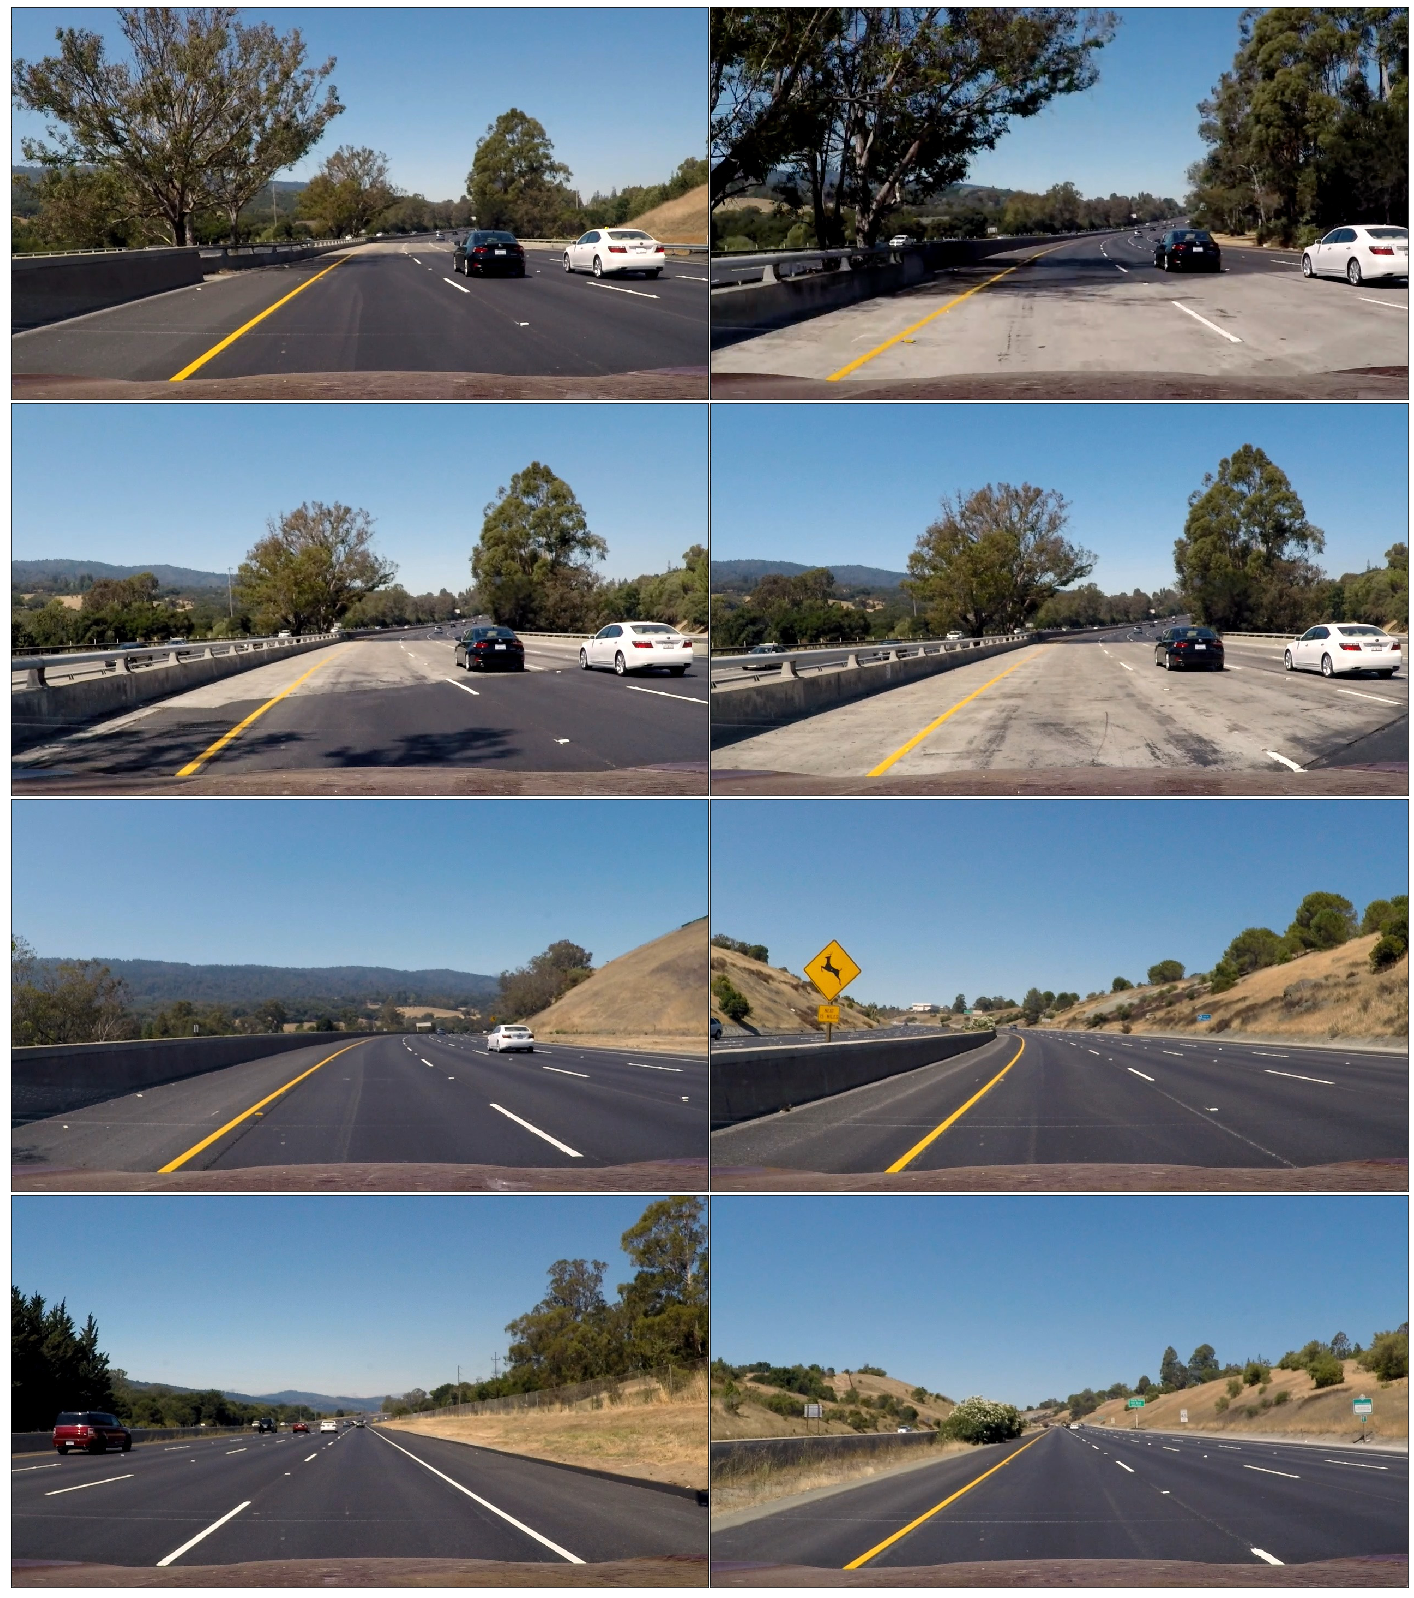

In [4]:
def show_images(images, cols = 2, cmap=None):
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(20, 22))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        try:
            cmap = 'gray' if len(image.shape)==2 else cmap
        except AttributeError:
            cmap = None
            
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

def multi_ret_map (func,parameter):
    temp_list = list(map(func,parameter))
    result_list = []
    for i in range(len(temp_list)):
        result_list.extend(temp_list[i])
    return result_list

test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]
show_images(test_images)

Now lets try RGB filter first with a 200 to 255 threhold value:

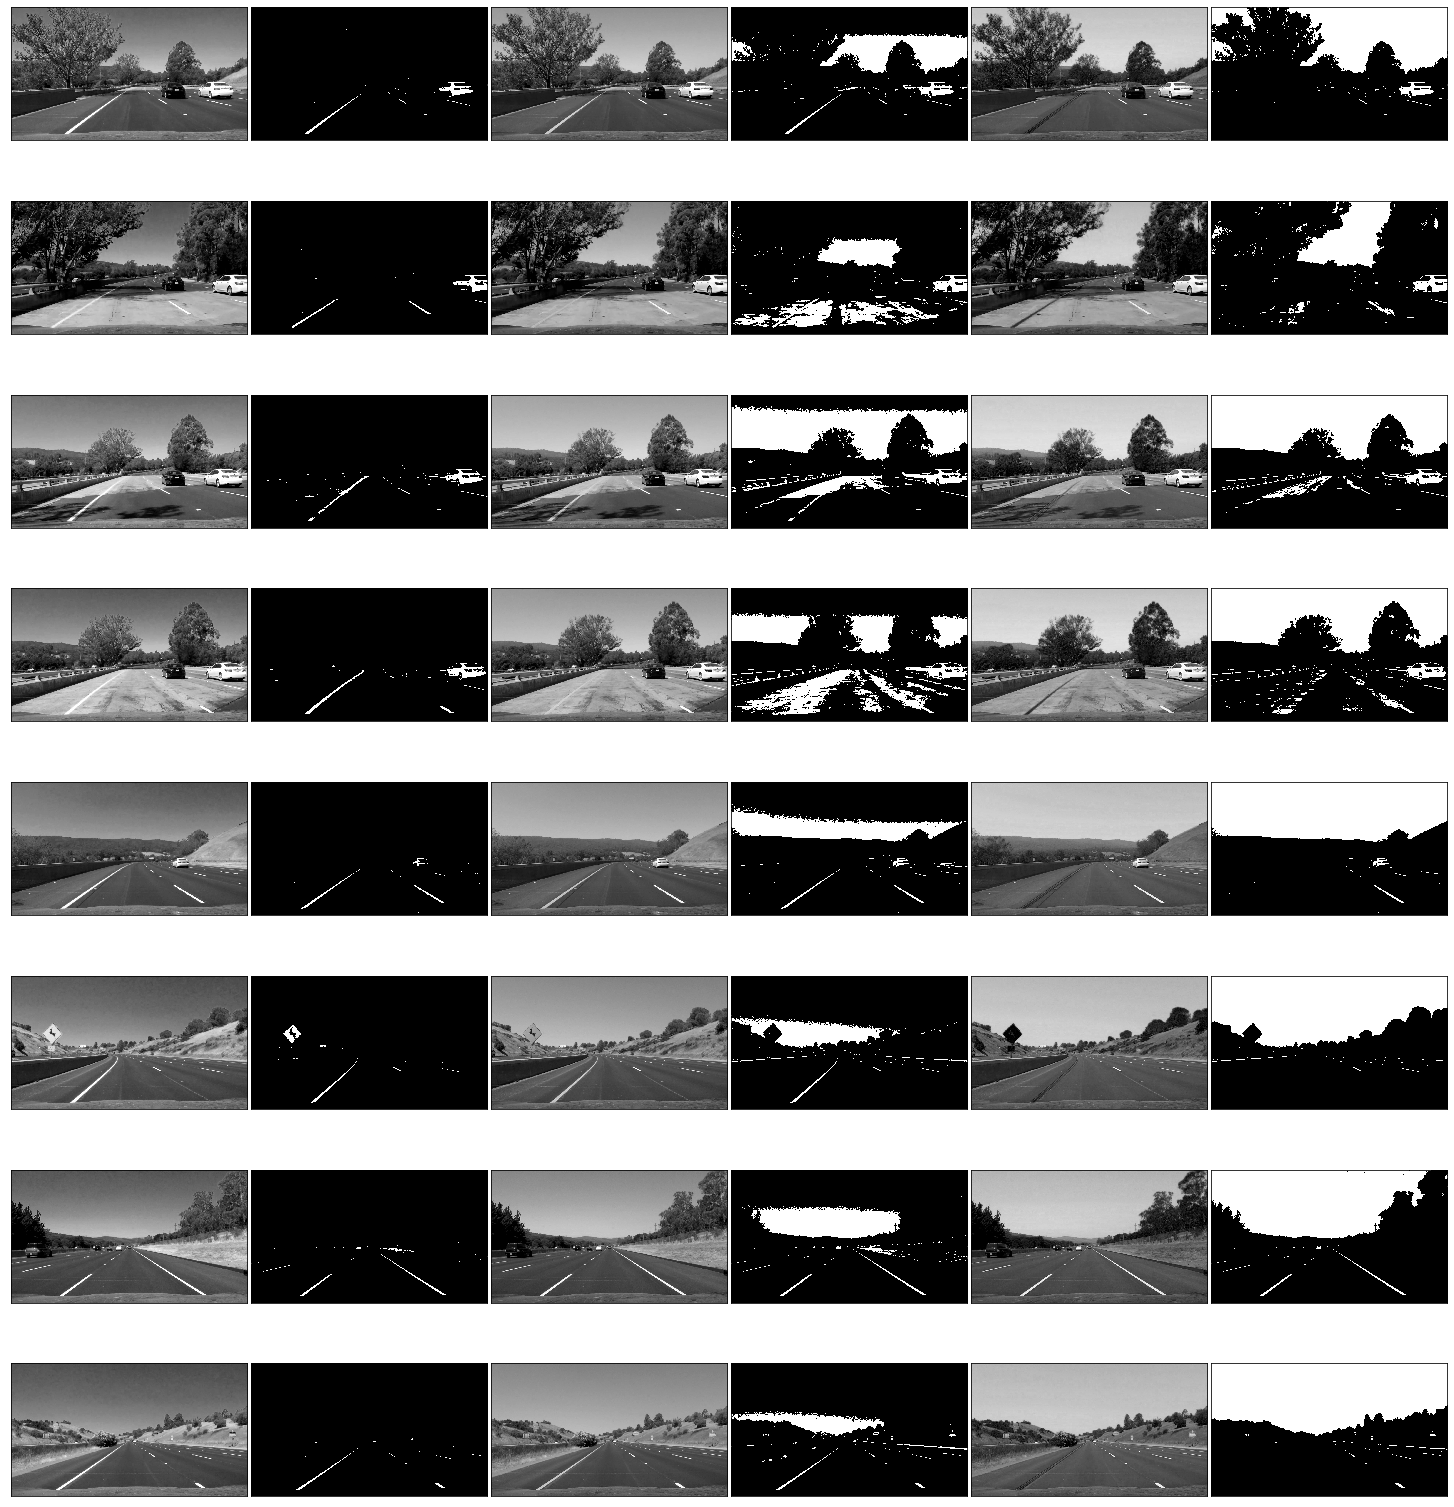

In [5]:
def covert_rgb (image): 
    R =image[:,:,0]
    G =image[:,:,1]
    B =image[:,:,2]
    thresh_r = [220,255]
    thresh_g = [170,255]
    binary_r = np.zeros_like(R)
    binary_g = np.zeros_like(G)
    binary_b = np.zeros_like(B)
    
    binary_r[(R > thresh_r[0]) & (R <= thresh_r[1])] = 1
    binary_g[(G > thresh_g[0]) & (G<= thresh_g[1])] = 1
    binary_b[(B >thresh_g[0]) & (B<= thresh_g[1])] = 1
    
    return  R,binary_r,G,binary_g,B,binary_b

    
show_images(multi_ret_map(covert_rgb,test_images), cols=6)

After experiment, only R shows a general good lane lines. Blue does not show yellow lines at all and G is failed to show plot 2 yellow line due to the pavement color change and the shadows.

However, R still is weak on low contrast area like plot 4, where pavement color is light.

Now lets experiment with HLS and HVS color space.

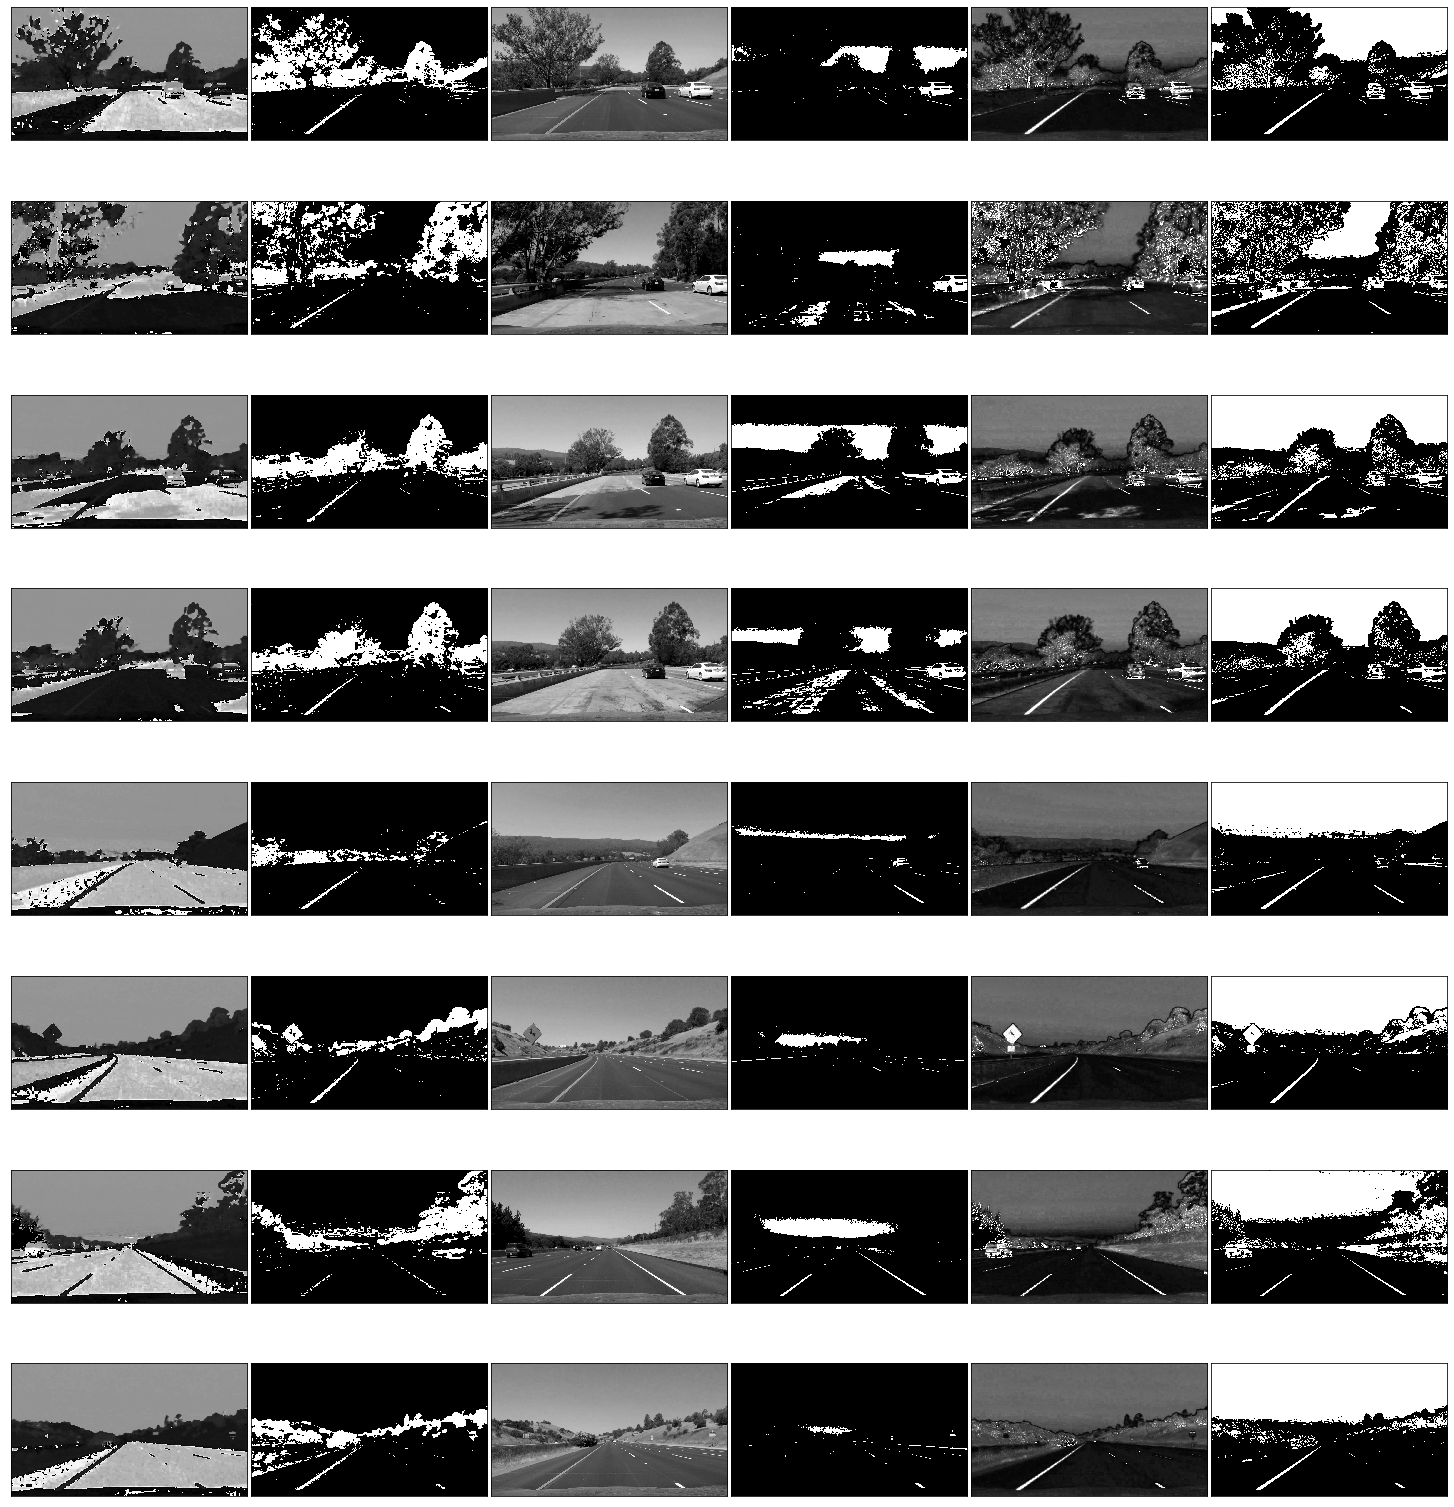

In [6]:
def convert_hls (image):
    hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary_h = np.zeros_like(H)
    binary_l = np.zeros_like(L)
    binary_s = np.zeros_like(S)
    
    thresh_h = [18,100]
    thresh_l = [180,255]
    thresh_s = [90,255]
    binary_h[(H > thresh_h[0]) & (H <= thresh_h[1])] = 1
    binary_l[(L > thresh_l[0]) & (L<= thresh_l[1])] = 1
    binary_s[(S >thresh_s[0]) & (S<= thresh_s[1])] = 1
    
    return H,binary_h,L,binary_l,S,binary_s

show_images(multi_ret_map(convert_hls,test_images), cols=6)

In summary, S with a `[90,255]` threshold works well across all test images.
H with a `[18,100]` looks decent but we need to compare with hsv to see if it's usable
L is no good

Now let's see how HVS looks like:

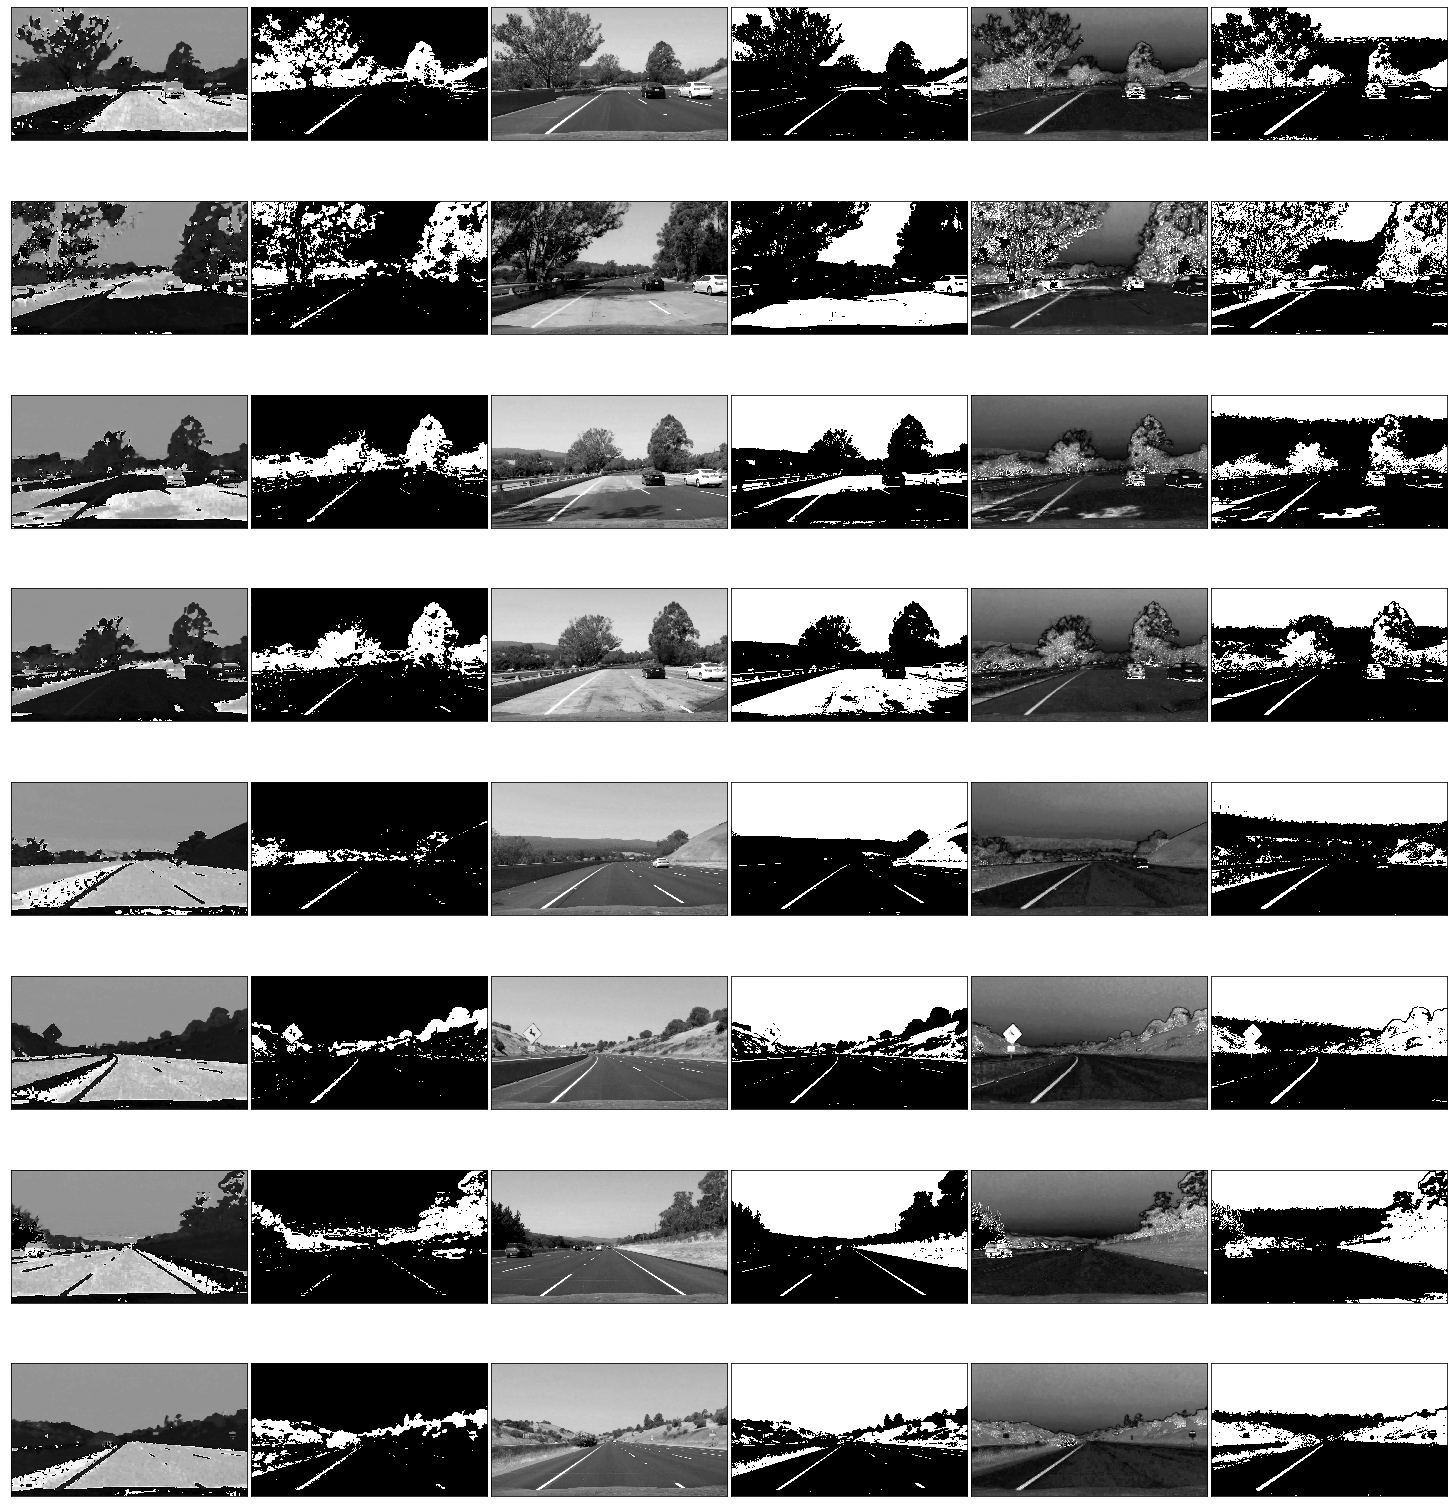

In [7]:
def convert_hsv (image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    V = hsv[:,:,2]
    binary_h = np.zeros_like(H)
    binary_v = np.zeros_like(V)
    binary_s = np.zeros_like(S)
    
    thresh_h = [18,100]
    thresh_v = [150,255]
    thresh_s = [90,255]
    binary_h[(H > thresh_h[0]) & (H <= thresh_h[1])] = 1
    binary_v[(V > thresh_v[0]) & (V<= thresh_v[1])] = 1
    binary_s[(S >thresh_s[0]) & (S<= thresh_s[1])] = 1
    return H,binary_h,V,binary_v,S,binary_s

show_images(multi_ret_map(convert_hsv,test_images), cols=6)

S in HSV detect yellow line super well, but it does not pick up white line at all.
S in HLS detect both yellow line and white line pretty well.

H in HSV and HLS behavior almost the same, we could use either of them.

L and V are influenced by the light pavement too much. We are not going to use those.

In summary, we could use (S in HLS or ( H in HLS and R in RGB)

## Gradient 
Use Sobel operator to calculate gray scale magnitude, direction of the gradient to find lane lines among all the other lines in the image

CPU times: user 973 ms, sys: 308 ms, total: 1.28 s
Wall time: 1.48 s
CPU times: user 289 ms, sys: 110 ms, total: 398 ms
Wall time: 390 ms


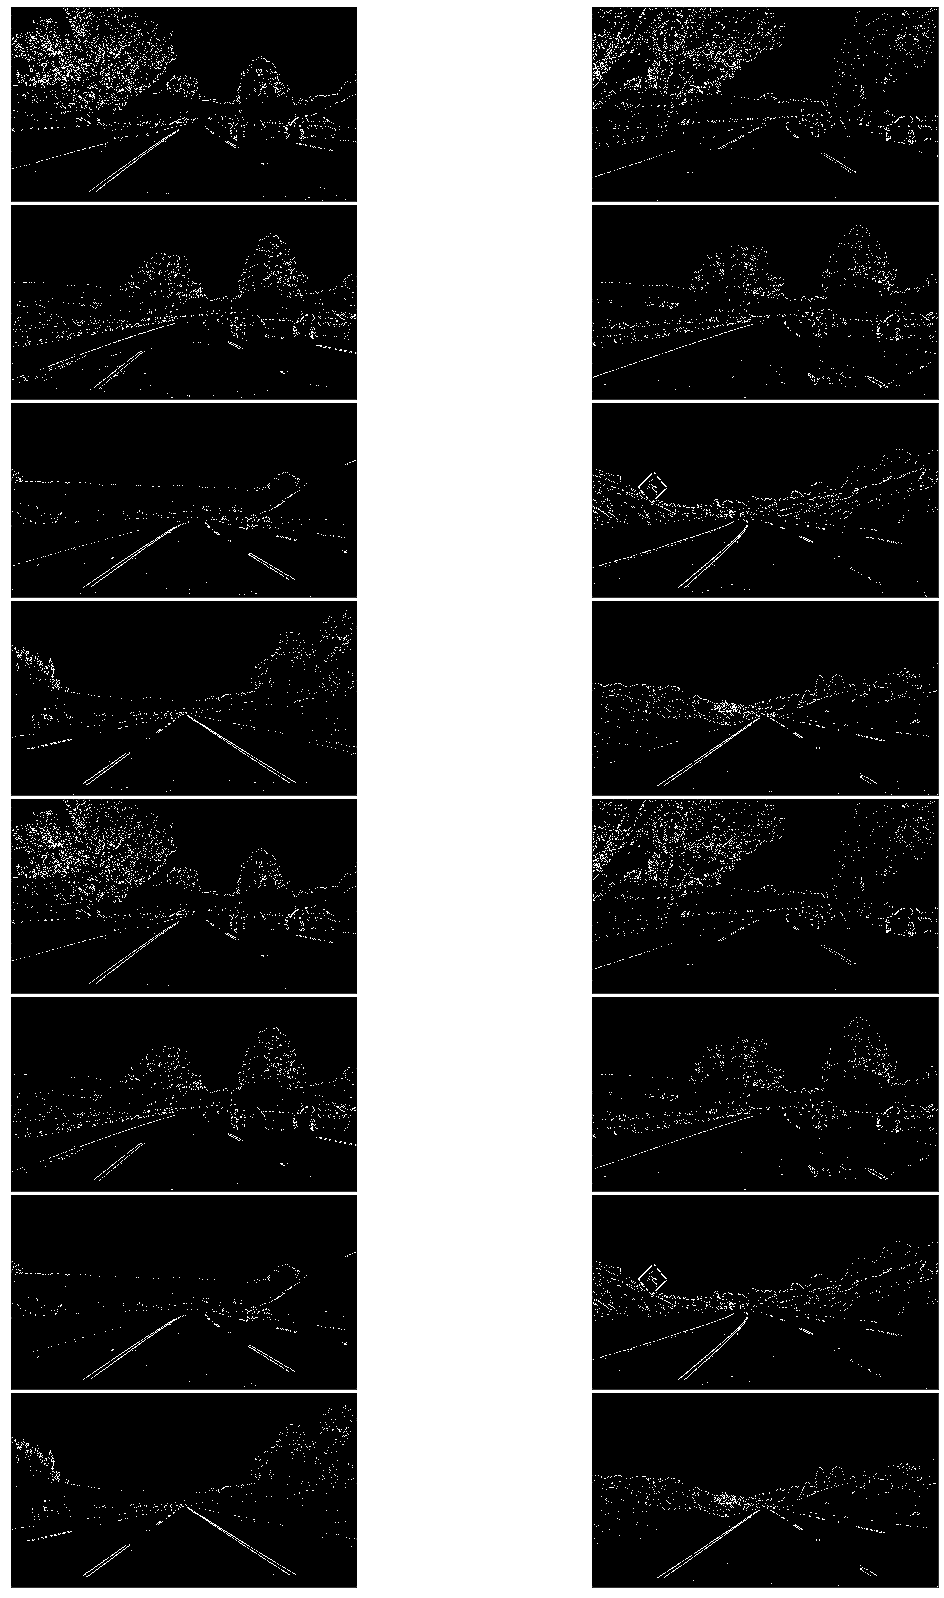

In [89]:
def abs_sobel_thresh(gray, orient='x', thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_threshold(gray, sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_arctan = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(abs_arctan)
    binary_output[(abs_arctan >= thresh[0]) & (abs_arctan <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    
    return binary_output


def sobel_gradient (image, overdrive = True, ksize = 3):
    # Choose complexity True means more complicated calculation
    abs_thresh = (25,200)
    mag_thresh = (40,150)
    dir_thresh = (0.7,1.3)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply each of the thresholding functions according to the compliexity
    gradx = abs_sobel_thresh(gray, orient='x', thresh=abs_thresh)
    grady = abs_sobel_thresh(gray, orient='y', thresh=abs_thresh)
    combined = np.zeros_like(grady)
    # If min complexity require only execute x and y gradient
    if overdrive: 
        mag_binary = mag_threshold(gray,sobel_kernel=ksize,thresh= mag_thresh)
        dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=dir_thresh)
        combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    else:
        combined[(gradx == 1) & (grady == 1)] = 1       
        
    return combined
%time templist = list(map(sobel_gradient,test_images))

%time templist.extend(list(map(sobel_gradient,test_images,[False]*len(test_images))))

#templist = list(map(sobel_gradient,test_images,[False]*len(test_images)))
#templist = list(map(dir_threshold,test_images,[15]*len(test_images),[(0.7,1.3)]*len(test_images)))
#templist = list(map(mag_threshold,test_images,[15]*len(test_images),[(40,150)]*len(test_images)))
show_images(templist)


After tuning each Sobel function, I have reached following threshold parameters:
```
abs_thresh = (25,200)
mag_thresh = (40,150)
dir_thresh = (0.7,1.3)
```
I combine the x,y direction sobel, magnitude and direction filter in `sobel_gradient()`. I also include a overdrive flag to save run time if need. For only doing xy direction, runtime is around 398ms and to do the full three function combine would take 1.28s. This is about almost 1s different computation time per frame later in the video processing.
```
CPU times: user 973 ms, sys: 308 ms, total: 1.28 s
Wall time: 1.48 s
CPU times: user 289 ms, sys: 110 ms, total: 398 ms
Wall time: 390 ms
```

## Combing color filter and gradient filter together
Now, let's build a complete image/frame processing logic by applying color space filter first and then applied above threshold filter to prepare for our lane detection pipeline.